In [1]:
# python版本大于3.5
import sys
assert sys.version_info >= (3,5)

# Scikit-Learn 版本大于 0.2
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow 版本大于 2.0
import tensorflow as tf
assert tf.__version__ >= "2.0"

import numpy as np
import os

# 使 notebook 每次有固定的输出
np.random.seed(42)

# 绘制图形
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 图形的保存路径
PROJECT_ROOT_DIR = os.getcwd()
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2022-11-06 10:37:19.009327: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.10.0'

In [3]:
keras.__version__

'2.10.0'

## 一、使用顺序API构建图像分类器 
首先，我们需要加载数据集。使用Fashion MNIST数据集，它是MNIST的直接替代品。

### 1、使用Keras加载数据集

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

当使用Keras而不是Scikit-Learn来加载MNIST或Fashion MNIST时，一个重要的区别是每个图像都表示为28×28阵列，而不是尺寸为784的一维阵列。此外，像素强度表示为整数（从0到255）而不是浮点数（从0.0到255.0）。

看一下训练集的形状和数据类型：

In [5]:
X_train_full.shape

(60000, 28, 28)

In [6]:
X_train_full.dtype

dtype('uint8')

In [7]:
X_test.shape

(10000, 28, 28)

请注意，数据集已经分为训练集和测试集，但是没有验证集，因此我们现在创建一个。另外，由于我们要使用梯度下降训练神经网络，因此必须比例缩放输入特征。为了简单起见，我们将像素强度除以255.0（将它们转换为浮点数），将像素强度降低到0～1范围内：

In [8]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [9]:
import matplotlib.pyplot as plt
def show_pic(train_datasets):
    plt.imshow(train_datasets[0], cmap="binary")
    plt.axis('off')
    plt.show()

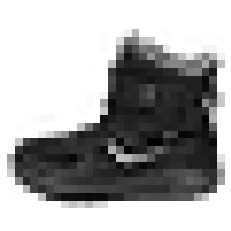

In [10]:
show_pic(X_train_full)

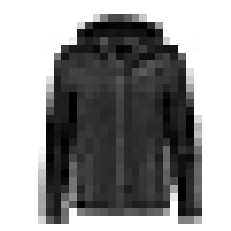

In [11]:
show_pic(X_train)

对于MNIST，当标签等于5时，说明图像代表手写数字5。但是，对于Fashion MNIST，我们需要一个类名列表来知道我们要处理的内容：

In [12]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [13]:
class_names[y_train[0]]

'Coat'

In [14]:
X_valid.shape

(5000, 28, 28)

查看来自Fashion MNIST数据集的一些示例。

Saving figure fashion_mnist_plot


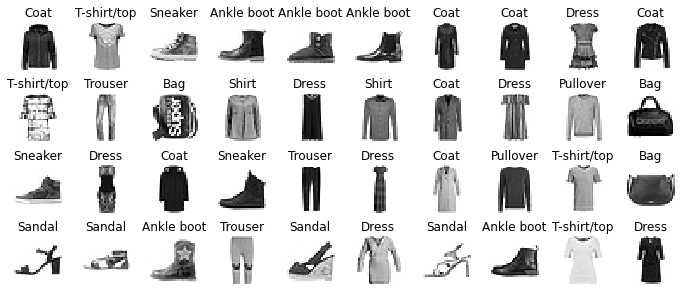

In [15]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

### 2、使用顺序API创建模型
建立神经网络：具有两个隐藏层的分类MLP

In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

2022-11-06 10:38:08.826584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


* 第一行创建一个Sequential模型。这是用于神经网络的最简单的Keras模型，它仅由顺序连接的单层堆栈组成。这称为顺序API。
* 接下来，我们构建第一层并将其添加到模型中。它是Flatten层，其作用是将每个输入图像转换为一维度组：如果接收到输入数据X，则计算X.reshape（-1，1）。该层没有任何参数。它只是在那里做一些简单的预处理。由于它是模型的第一层，因此应指定input_shape，其中不包括批处理大小，而仅包括实例的形状。或者，你可以添加keras.layers.InputLayer作为第一层，设置input_shape=[28，28]。
* 接下来，我们添加具有300个神经元的Dense隐藏层。它使用ReLU激活函数。每个Dense层管理自己的权重矩阵，其中包含神经元及其输入之间的所有连接权重。它还管理偏置项的一个向量（每个神经元一个）。当它接收到一些输入数据时，它计算公式10-2。
* 然后，我们添加第二个有100个神经元的Dense隐藏层，还是使用ReLU激活函数。
* 最后，我们添加一个包含10个神经元的Dense输出层（每个类一个），使用softmax激活函数（因为这些类是排他的）。

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [18]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
# 可以不用像我们刚才那样逐层添加层，而可以在创建顺序模型时传递一个层列表：
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

模型的summary（）方法显示模型的所有层，包括每个层的名称（除非在创建层时进行设置，否则会自动生成），其输出形状（None表示批处理大小任意），以及它的参数数量。总结以参数总数结尾，包括可训练参数和不可训练的参数。在这里，我们只有可训练的参数

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [21]:
!pip install pydot

In [22]:
!pip install pydotplus

In [23]:
!pip install graphviz

In [21]:
import pydotplus as pydot
print (pydot.find_graphviz())

{'dot': '/usr/local/bin/dot', 'twopi': '/usr/local/bin/twopi', 'neato': '/usr/local/bin/neato', 'circo': '/usr/local/bin/circo', 'fdp': '/usr/local/bin/fdp', 'sfdp': '/usr/local/bin/sfdp'}


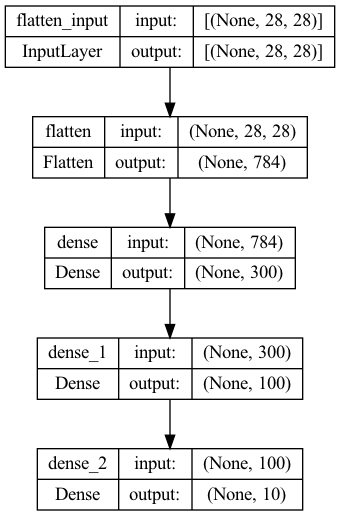

In [22]:
from tensorflow.keras.utils import plot_model

keras.utils.plot_model(model, "images/ann/my_fashion_mnist_model.png", show_shapes=True)

请注意，密集层通常具有很多参数。例如，第一个隐藏层的连接权重为784×300，外加300个偏置项，总共有235 500个参数！这为模型提供了足够的灵活性来拟合训练数据，但这也意味着模型存在过拟合的风险，尤其是在你没有大量训练数据的情况下。

我们可以轻松获取模型的层列表，按其索引获取层，也可以按名称获取：

In [23]:
model.layers

In [24]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [25]:
model.get_layer('dense') is hidden1

True

In [26]:
hidden2 = model.layers[2]
hidden2.name

'dense_1'

可以使用get_weights（）和set_weights（）方法访问层的所有参数。对于密集层，这包括连接权重和偏置项：

In [27]:
weights, biases = hidden1.get_weights()
weights

array([[-0.06327549,  0.04607336, -0.00018382, ..., -0.05912905,
         0.04769796,  0.0657828 ],
       [ 0.03080453, -0.02235255, -0.04378828, ...,  0.04132159,
        -0.0362041 ,  0.02353462],
       [ 0.0506324 ,  0.07436727, -0.07188004, ..., -0.02712691,
         0.00524481, -0.0742265 ],
       ...,
       [-0.05959373,  0.06043352,  0.01891084, ...,  0.06103815,
         0.00903047, -0.06452976],
       [ 0.06540149,  0.0656873 , -0.01556693, ...,  0.00264021,
        -0.07074748, -0.07305554],
       [-0.03419486, -0.0002784 ,  0.05311382, ...,  0.04671833,
        -0.03605552, -0.01387393]], dtype=float32)

In [28]:
weights.shape

(784, 300)

注意，密集层随机初始化了连接权重（这是打破对称性所必需的，正如我们前面所讨论的），并且偏置被初始化为零，这是可以的。如果要使用其他初始化方法，则可以在创建层时设置kernel_initializer（内核是连接权重矩阵的另一个名称）或bias_initializer。

In [29]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [30]:
biases.shape

(300,)

In [31]:
weights2, biases = hidden2.get_weights()
weights2.shape

(300, 100)

### 3、编译模型
创建模型后，我们必须调用compile（）方法来指定损失函数和要使用的优化器。我们也可以选择指定在训练和评估期间要计算的其他指标：

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="sgd",
             metrics=["accuracy"])

形式等于
`model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
`         
* 首先，我们使用"sparse_categorical_crossentropy"损失，因为我们具有稀疏标签（即对于每个实例，只有一个目标类索引，在这种情况下为0到9），并且这些类是互斥的。相反，如果每个实例的每个类都有一个目标概率（例如独热向量，[0.，0.，0.，1.，0.，0.，0.，0.，0.，0]代表类3），则我们需要使用"categorical_crossentropy"损失。如果我们正在执行二进制分类（带有一个或多个二进制标签），则在输出层中使用"sigmoid"（即逻辑）激活函数，而不是"softmax"激活函数，并且使用"binary_crossentropy"损失。
* 关于优化器，"sgd"表示我们使用简单的随机梯度下降来训练模型。换句话说，Keras将执行先前所述的反向传播算法（即反向模式自动微分加梯度下降）。
* 最后，由于这是一个分类器，因此在训练和评估过程中测量其"accuracy"很有用。

### 4、训练和评估模型
现在该模型已准备好进行训练。为此我们只需要调用其fit（）方法即可：

In [33]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7162 - accuracy: 0.7663 - val_loss: 0.5253 - val_accuracy: 0.8244
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4902 - accuracy: 0.8278 - val_loss: 0.4362 - val_accuracy: 0.8502
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4441 - accuracy: 0.8439 - val_loss: 0.5134 - val_accuracy: 0.8064
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4171 - accuracy: 0.8543 - val_loss: 0.3967 - val_accuracy: 0.8634
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3981 - accuracy: 0.8609 - val_loss: 0.3773 - val_accuracy: 0.8664
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3792 - accuracy: 0.8668 - val_loss: 0.3720 - val_accuracy: 0.8748
Epoch 7/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3665 - accuracy: 0.8705 - val_loss: 0.3627 - val_accuracy:

我们将输入特征（X_train）和目标类（y_train）以及要训练的轮次数传递给它（否则它将默认为1，这绝对不足以收敛为一个好的模型）。我们还传递了一个验证集（这是可选的）。Keras将在每个轮次结束时测量此集合上的损失和其他指标，这对于查看模型的实际效果非常有用。如果训练集的性能好于验证集，则你的模型可能过拟合训练集（或者存在错误，例如训练集和验证集之间的数据不匹配）。

这样就训练了神经网络。在训练期间的每个轮次，Keras会显示到目前为止已处理的实例数（以及进度条）、每个样本的平均训练时间、损失和精度（或我们要求的任何其他额外指标）（针对训练集和验证集）。我们可以看到训练损失减少了，这是一个好兆头，经过30个轮次后，验证准确率达到了88.48％。这与训练精确率相差不大，因此似乎并没有发生过拟合现象。

> 我们可以将validation_split设置为希望Keras用于验证的训练集的比率，而不是使用validation_data参数传递验证集。例如，validation_split=0.1告诉Keras使用数据的最后10％（在乱序之前）进行验证。

如果训练集非常不平衡，其中某些类的代表过多，而其他类的代表不足，那么在调用fit（）方法时设置class_weight参数会很有用，这给代表性不足的类更大的权重，给代表过多的类更小的权重。Keras在计算损失时将使用这些权重。如果我们需要每个实例的权重，设置sample_weight参数（如果class_weight和sample_weight都提供了，Keras会把它们相乘）。如果某些实例由专家标记，而另一些实例使用众包平台标记，则按实例权重可能会有用：我们可能希望为前者赋予更多权重。我们还可以通过将其作为validation_data元组的第三项添加到验证集中来提供样本权重（但不提供类权重）。

In [34]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [35]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


如上，fit（）方法返回一个History对象，其中包含训练参数（history.params）、经历的轮次列表（history.epoch），最重要的是包含在训练集和验证集（如果有）上的每个轮次结束时测得的损失和额外指标的字典（history.history）。

如果使用此字典创建pandas DataFrame并调用其plot（）方法，则会获得下图所示的学习曲线：

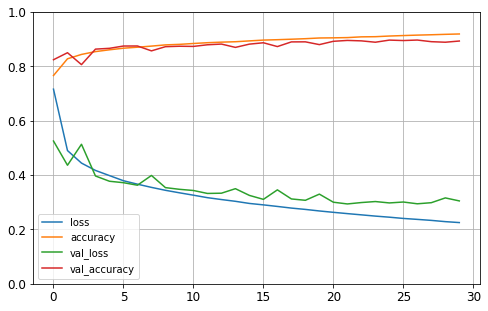

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

可以看到训练期间训练准确率和验证准确率都在稳步提高，而训练损失和验证损失则在下降。而且，验证曲线与训练曲线很接近，这意味着没有太多的过拟合。在这种特殊情况下，该模型看起来在验证集上的表现要好于训练开始时在训练集上的表现。但是事实并非如此：确实，验证误差是在每个轮次结束时计算的，而训练误差是使用每个轮次的运行平均值计算的。因此，训练曲线应向左移动半个轮次。如果这样做，你会看到训练和验证曲线在训练开始时几乎完全重叠。
> 绘制训练曲线时，应将其向左移动半个轮次。

训练集的性能最终会超过验证性能，就像通常情况下训练足够长的时间一样。可以说模型尚未完全收敛，因为验证损失仍在下降，因此我们可能应该继续训练。这就像再次调用fit（）方法那样简单，因为Keras只是从它停止的地方继续训练。

如果对模型的性能不满意，则应回头调整超参数。首先要检查的是学习率。如果这样做没有帮助，尝试使用另一个优化器（并在更改任何超参数后始终重新调整学习率）。如果性能仍然不佳，则尝试调整模型超参数（例如层数、每层神经元数以及用于每个隐藏层的激活函数的类型）。还可以尝试调整其他超参数，例如批处理大小（可以使用batch_size参数在fit（）方法中进行设置，默认为32）。最后，我们将回到超参数调整。

对模型的验证精度感到满意后，应在测试集上对其进行评估泛化误差，然后再将模型部署到生产环境中。我们可以使用evaluate（）方法轻松完成此操作（它还支持其他几个参数，例如batch_size和sample_weight，请查看文档以获取更多详细信息）

In [37]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 1ms/step - loss: 74.5497 - accuracy: 0.8344


[74.54969024658203, 0.8343999981880188]

### 5、使用模型进行预测
接下来，我们可以使用模型的predict（）方法对新实例进行预测。由于没有实际的新实例，因此我们将仅使用测试集的前三个实例：

In [38]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 93ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

如果我们只关心估计概率最高的类（即使该概率非常低），则可以使用下述方法：

In [39]:
import numpy as np
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 24ms/step


array([9, 2, 1])

In [40]:
y_test[:3]

array([9, 2, 1], dtype=uint8)

In [41]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Saving figure fashion_mnist_images_plot


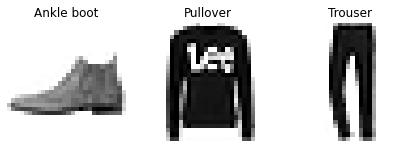

In [42]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## 二、使用顺序API构建回归MLP
让我们转到加州的住房问题，并使用回归神经网络解决它。为简单起见，我们将使用Scikit-Learn的fetch_california_housing（）函数加载数据。该数据集比我们在第2章中使用的数据集更简单，因为它仅包含数字特征（没有ocean_proximity特征），并且没有缺失值。加载数据后，我们将其分为训练集、验证集和测试集，然后比例缩放所有特征：

In [43]:
from sklearn import datasets
print(datasets.get_data_home())

/Users/dayao/scikit_learn_data


In [ ]:
?fetch_california_housing 

In [44]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

X_train.shape

(11610, 8)

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

In [46]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.1749 - val_loss: 0.9321
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7913 - val_loss: 0.7251
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6932 - val_loss: 0.6897
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6586 - val_loss: 0.6642
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6334 - val_loss: 0.6406
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6109 - val_loss: 0.6213
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.6047
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5773 - val_loss: 0.5888
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5637 - val_loss: 0.5759
Epoch 10/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5514 - val_loss: 0.5636

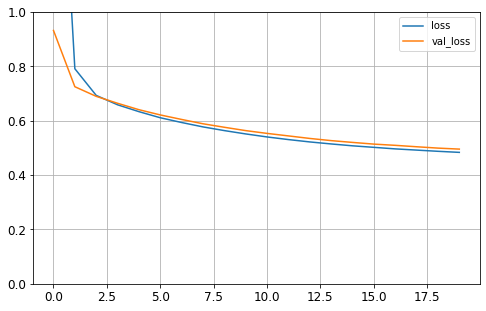

In [47]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [48]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.4998


In [49]:
X_new = X_test[:3]
y_pred = model.predict(X_new)
y_pred

1/1 [==============================] - 0s 56ms/step


array([[0.64357615],
       [1.511163  ],
       [3.1041212 ]], dtype=float32)

In [50]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

### 三、使用函数式API构建复杂模型
非顺序神经网络的一个示例是“宽深”神经网络。这种神经网络架构是由Heng-Tze Cheng等人在2016年发表的论文引入的。它将所有或部分输入直接连接到输出层，如图10-14所示。这种架构使神经网络能够学习深度模式（使用深度路径）和简单规则（通过短路径）。相比之下，常规的MLP迫使所有数据流经整个层的堆栈。

因此，数据的简单模式最终可能会因为顺序被转换而失真。

In [51]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [52]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])

* 首先，我们需要创建一个Input对象。这是模型需要的输入类型的规范，包括其shape和dtype。我们很快就会看到，一个模型实际上可能有多个输入。
* 接下来，我们创建一个包含30个神经元的Dense层，使用ReLU激活函数。创建它后，请注意，我们像调用函数一样将其传递给输入。这就是将其称为函数式API的原因。注意，我们只是在告诉Keras它应该如何将各层连接在一起。尚未处理任何实际数据。
* 然后，我们创建第二个隐藏层，然后再次将其用作函数。请注意，我们将第一个隐藏层的输出传递给它。
* 接下来，我们创建一个Concatenate层，再次像函数一样立即使用它来合并输入和第二个隐藏层的输出。你可能更喜欢keras.layers.concatenate（）函数，该函数创建一个Concatenate层并立即使用给定的输入对其进行调用。
* 然后我们创建具有单个神经元且没有激活函数的输出层，然后像函数一样调用它，将合并结果传递给它。
* 最后，我们创建一个Keras Model，指定要使用的输入和输出。

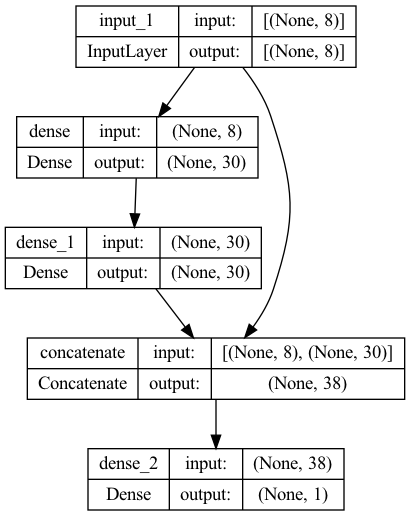

In [53]:
keras.utils.plot_model(model, "images/ann/my_function_api_model.png", show_shapes=True)
# 图：宽深神经网络

In [54]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 30)           270         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 30)           930         ['dense[0][0]']                  
                                                                                                  
 concatenate (Concatenate)      (None, 38)           0           ['input_1[0][0]',                
                                                                  'dense_1[0][0]']            

In [55]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.3624 - val_loss: 0.9074
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.8198 - val_loss: 0.7607
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7378 - val_loss: 0.6962
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6674 - val_loss: 0.6593
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6363 - val_loss: 0.6266
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6033 - val_loss: 0.6040
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5826 - val_loss: 0.5872
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5660 - val_loss: 0.5732
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5529 - val_loss: 0.5618
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5420 - val_loss: 0.5519

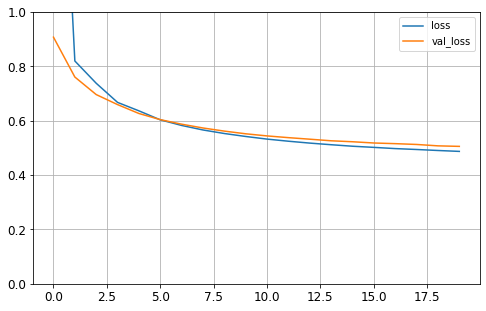

In [56]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [57]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.4955


In [58]:
y_pred = model.predict(X_new)
y_pred

1/1 [==============================] - 0s 63ms/step


array([[0.63555753],
       [1.5165563 ],
       [2.8890243 ]], dtype=float32)

In [59]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

如果你想通过宽路径送入特征的子集，而通过深路径送入特征的另一个子集（可能有重合）呢？在这种情况下，一种解决方案是使用多个输入。例如，假设我们要通过宽路径送入5个特征（特征0到4），并通过深路径送入6个特征（特征2到7）：

In [60]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

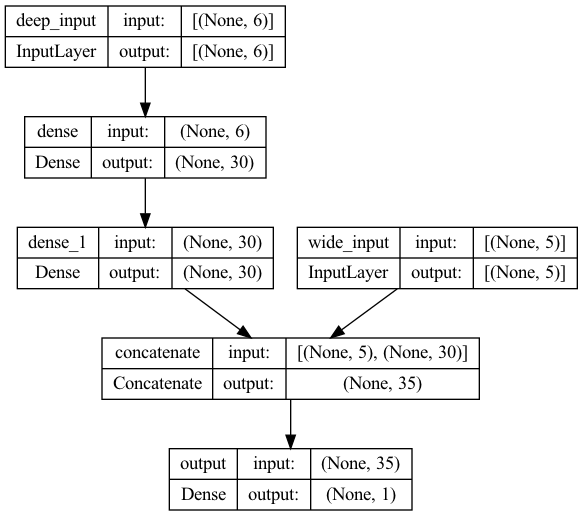

In [62]:
keras.utils.plot_model(model, "images/ann/my_function_api_model1.png", show_shapes=True)
# 图：处理多输入

在创建模型时，我们指定了input=[input_A，input_B]。现在我们可以像往常一样编译模型了，但是当我们调用fit（）方法时，必须传递一对矩阵（X_train_A，X_train_B）：各输入一个矩阵，而不是传递单个输入矩阵X_train。当你调用evaluate（）或predict（）时，X_valid、X_test和X_new同样如此：

In [63]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20, validation_data=((X_valid_A, X_valid_B), y_valid))

Epoch 1/20


/Users/dayao/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


363/363 [==============================] - 1s 2ms/step - loss: 2.0963 - val_loss: 1.0243
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8694 - val_loss: 0.7382
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.7038 - val_loss: 0.6653
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6472 - val_loss: 0.6295
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6123 - val_loss: 0.6027
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5859 - val_loss: 0.5837
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5659 - val_loss: 0.5686
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5508 - val_loss: 0.5566
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5393 - val_loss: 0.5468
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5301 - val_loss: 0.5389
Epoch 11/2

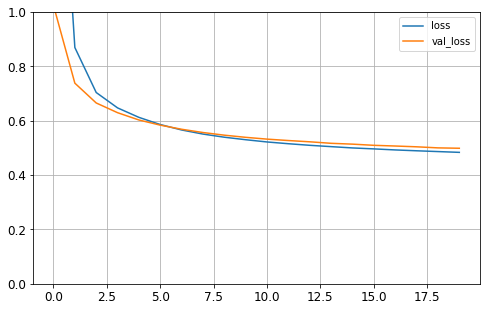

In [64]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [65]:
mse_test = model.evaluate((X_test_A,X_test_B), y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.4911


In [66]:
y_pred = model.predict((X_new_A, X_new_B))
y_pred

1/1 [==============================] - 0s 62ms/step


array([[0.50993216],
       [1.6746781 ],
       [2.8180852 ]], dtype=float32)

In [67]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

在许多用例中，你可能需要多个输出：
* 例如，你可能想在图片中定位和分类主要物体。这既是回归任务（查找物体中心的坐标以及宽度和高度），又是分类任务。
* 同样，你可能有基于同一数据的多个独立任务。当然你可以为每个任务训练一个神经网络，但是在许多情况下，通过训练每个任务一个输出的单个神经网络会在所有任务上获得更好的结果。这是因为神经网络可以学习数据中对任务有用的特征。例如，你可以对面部图片执行多任务分类，使用一个输出对人的面部表情进行分类（微笑、惊讶等），使用另一个输出来识别他们是否戴着眼镜。
* 另一个示例是作为正则化技术（即训练约束，其目的是减少过拟合，从而提高模型的泛化能力）。例如，你可能希望在神经网络结构中添加一些辅助输出（见下述内容），以确保网络的主要部分自己能学习有用的东西，而不依赖于网络的其余部分。

添加额外的输出非常容易：只需将它们连接到适当的层，然后将它们添加到模型的输出列表中即可。例如，

In [68]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [69]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

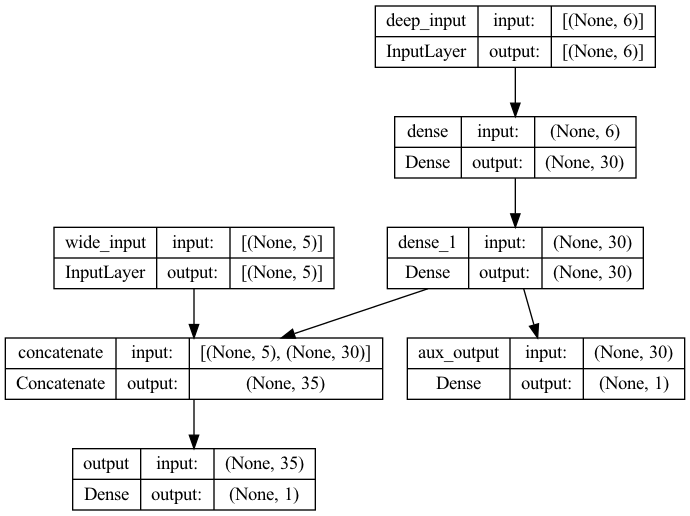

In [70]:
keras.utils.plot_model(model, "images/ann/my_function_api_model2.png", show_shapes=True)
# 图：处理多输入

每个输出都需要自己的损失函数。因此当我们编译模型时，应该传递一系列损失（如果传递单个损失，Keras将假定所有输出必须使用相同的损失）。默认情况下，Keras将计算所有这些损失，并将它们简单累加即可得到用于训练的最终损失。我们更关心主要输出而不是辅助输出（因为它仅用于正则化），因此我们要给主要输出的损失更大的权重。幸运的是，可以在编译模型时设置所有的损失权重：

In [71]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")

现在当训练模型时，需要为每个输出提供标签。在此示例中，主要输出和辅助输出应预测出相同的结果，因此它们应使用相同的标签。除了传递y_train之外，还需要传递（y_train，y_train）（对于y_valid和y_test也是如此）：

In [72]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20, 
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.9404 - output_loss: 0.8254 - aux_output_loss: 1.9756 - val_loss: 0.6675 - val_output_loss: 0.5987 - val_aux_output_loss: 1.2871
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5988 - output_loss: 0.5382 - aux_output_loss: 1.1446 - val_loss: 0.5629 - val_output_loss: 0.5096 - val_aux_output_loss: 1.0428
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5406 - output_loss: 0.4955 - aux_output_loss: 0.9462 - val_loss: 0.5355 - val_output_loss: 0.4971 - val_aux_output_loss: 0.8808
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5213 - output_loss: 0.4872 - aux_output_loss: 0.8278 - val_loss: 0.5149 - val_output_loss: 0.4835 - val_aux_output_loss: 0.7977
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4872 - output_loss: 0.4580 - aux_output_loss: 0.7498 - val_loss: 0.4971 - val_output_loss: 0.4698 - val_aux_

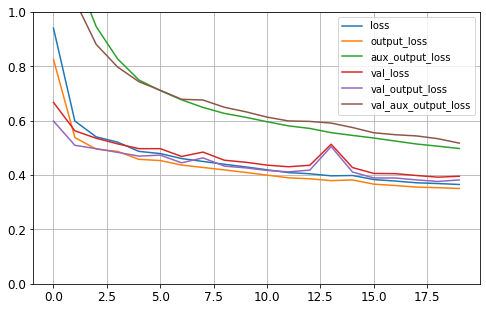

In [73]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

当评估模型时，Keras将返回总损失以及所有单个损失：

In [74]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])

162/162 [==============================] - 0s 1ms/step - loss: 0.3709 - output_loss: 0.3588 - aux_output_loss: 0.4795


同样，predict（）方法将为每个输出返回预测值：

In [75]:
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])
y_pred_main

1/1 [==============================] - 0s 74ms/step


array([[0.50306594],
       [1.6491497 ],
       [3.3968549 ]], dtype=float32)

In [76]:
y_pred_aux

array([[0.7255895],
       [1.8602827],
       [2.8143647]], dtype=float32)

### 4、使用子类API构建动态模型
……

### 5、保存和还原模型

In [77]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [78]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [80]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5289 - val_loss: 0.5498
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5159 - val_loss: 0.5383
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5044 - val_loss: 0.5265
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4951 - val_loss: 0.5200
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4874 - val_loss: 0.5118
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4792 - val_loss: 0.5022
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4740 - val_loss: 0.5000
Epoch 8/10
363/363 [==============================] - 0s 999us/step - loss: 0.4685 - val_loss: 0.4912
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4643 - val_loss: 0.4876
Epoch 10/10
162/162 [==============================] - 0s 758us/step - loss: 0.4713


In [81]:
model.save("model/my_keras_model.h5")

In [82]:
model = keras.models.load_model("model/my_keras_model.h5")

In [83]:
model.predict(X_new)

1/1 [==============================] - 0s 42ms/step


array([[0.5665424],
       [1.7019134],
       [3.3798182]], dtype=float32)

In [84]:
model.save_weights("model/my_keras_weights.ckpt")

In [85]:
model.load_weights("model/my_keras_weights.ckpt")

### 6、使用回调函数
fit（）方法接受一个callbacks参数，该参数使你可以指定Keras在训练开始和结束时，每个轮次的开始和结束时（甚至在处理每个批量之前和之后）将调用的对象列表。例如，在训练期间ModelCheckpoint回调会定期保存模型的检查点，默认情况下，在每个轮次结束时：

In [86]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [87]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [88]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/my_keras_model_check.h5")
history = model.fit(X_train, y_train, epochs=10, callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 1s 1ms/step - loss: 2.4273
Epoch 2/10
363/363 [==============================] - 0s 816us/step - loss: 1.0139
Epoch 3/10
363/363 [==============================] - 0s 854us/step - loss: 0.7564
Epoch 4/10
363/363 [==============================] - 0s 926us/step - loss: 0.6938
Epoch 5/10
363/363 [==============================] - 0s 907us/step - loss: 0.6629
Epoch 6/10
363/363 [==============================] - 0s 917us/step - loss: 0.6394
Epoch 7/10
363/363 [==============================] - 0s 865us/step - loss: 0.6190
Epoch 8/10
363/363 [==============================] - 0s 847us/step - loss: 0.6004
Epoch 9/10
363/363 [==============================] - 0s 979us/step - loss: 0.5830
Epoch 10/10
363/363 [==============================] - 0s 893us/step - loss: 0.5673


In [89]:
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 770us/step - loss: 0.5584


此外，如果在训练期间使用验证集，则可以在创建ModelCheckpoint时设置save_best_only=True。在这种情况下，只有在验证集上的模型性能达到目前最好时，它才会保存模型。这样，你就不必担心训练时间太长而过拟合训练集：只需还原训练后保存的最后一个模型，这就是验证集中的最佳模型。以下代码是实现提前停止的简单方法:

In [90]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("model/my_keras_model_check_valid.h5")
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb])

Epoch 1/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5524 - val_loss: 0.5492
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5393 - val_loss: 0.5363
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5278 - val_loss: 0.5258
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5168 - val_loss: 0.5176
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5077 - val_loss: 0.5087
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4991 - val_loss: 0.5027
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4919 - val_loss: 0.4957
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4852 - val_loss: 0.4901
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4792 - val_loss: 0.4856
Epoch 10/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4743 - val_loss: 0.4818

In [91]:
model = keras.models.load_model("model/my_keras_model_check_valid.h5") # 加载最佳模型
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 783us/step - loss: 0.4803


实现提前停止的另一种方法是使用EarlyStopping回调。如果在多个轮次（由patience参数定义）的验证集上没有任何进展，它将中断训练，并且可以选择回滚到最佳模型。我们可以将两个回调结合起来以保存模型的检查点（以防计算机崩溃），并在没有更多进展时尽早中断训练（以避免浪费时间和资源）：

In [92]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4691 - val_loss: 0.4784
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4646 - val_loss: 0.4733
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4607 - val_loss: 0.4701
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4567 - val_loss: 0.4680
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4535 - val_loss: 0.4642
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4499 - val_loss: 0.4630
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4473 - val_loss: 0.4592
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4443 - val_loss: 0.4569
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4416 - val_loss: 0.4551
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4396 - val_lo

363/363 [==============================] - 0s 1ms/step - loss: 0.3582 - val_loss: 0.3846
Epoch 82/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3574 - val_loss: 0.3861
Epoch 83/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3571 - val_loss: 0.3844
Epoch 84/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3564 - val_loss: 0.3838
Epoch 85/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3554 - val_loss: 0.3838
Epoch 86/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3549 - val_loss: 0.3824
Epoch 87/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3540 - val_loss: 0.3823
Epoch 88/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3536 - val_loss: 0.3801
Epoch 89/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3525 - val_loss: 0.3807
Epoch 90/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3523 - val_loss: 

In [93]:
mse_test = model.evaluate(X_test, y_test)
mse_test

162/162 [==============================] - 0s 969us/step - loss: 0.3653


0.36531370878219604

可以将轮次数设置为较大的值，因为训练将在没有更多进展时自动停止。在这种情况下，无须还原保存的最佳模型，因为EarlyStopping回调将跟踪最佳权重，并在训练结束时为你还原它。

如果需要额外的控制，则可以轻松编写自己的自定义回调。作为如何执行的示例，以下自定义回调将显示训练过程中验证损失与训练损失之间的比率（例如，检测过拟合）：

In [94]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train:{:.2f}".format(logs["val_loss"]/logs["loss"]))

In [95]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid), callbacks=[val_train_ratio_cb])

Epoch 1/5
312/363 [========================>.....] - ETA: 0s - loss: 0.3497
val/train:1.09
363/363 [==============================] - 0s 1ms/step - loss: 0.3455 - val_loss: 0.3756
Epoch 2/5
307/363 [========================>.....] - ETA: 0s - loss: 0.3495
val/train:1.08
363/363 [==============================] - 0s 1ms/step - loss: 0.3450 - val_loss: 0.3734
Epoch 3/5
363/363 [==============================] - ETA: 0s - loss: 0.3446
val/train:1.08
363/363 [==============================] - 0s 1ms/step - loss: 0.3446 - val_loss: 0.3729
Epoch 4/5
306/363 [========================>.....] - ETA: 0s - loss: 0.3435
val/train:1.09
363/363 [==============================] - 0s 1ms/step - loss: 0.3438 - val_loss: 0.3739
Epoch 5/5
336/363 [==========================>...] - ETA: 0s - loss: 0.3417
val/train:1.08
363/363 [==============================] - 0s 1ms/step - loss: 0.3438 - val_loss: 0.3726


### 7、使用TensorBoard进行可视化
TensorBoard是一款出色的交互式可视化工具，可用于在训练期间查看学习曲线；比较多次运行的学习曲线；可视化计算图；分析训练统计数据；查看由模型生成的图像；把复杂的多维数据投影到3D，自动聚类并进行可视化，等等！

要使用它，我们必须修改程序以便将要可视化的数据输出到名为事件文件的特殊二进制日志文件中。每个二进制数据记录称为摘要。TensorBoard服务器将监视日志目录，并将自动获取更改并更新可视化效果：这使我们可以可视化实时数据（有短暂延迟），例如训练期间的学习曲线。通常我们需要把TensorBoard服务器指向根日志目录并配置程序，以使其在每次运行时都写入不同的子目录。这样相同的TensorBoard服务器实例可以使我们可视化并比较程序多次运行中的数据，而不会混淆所有内容。

In [96]:
import os
# 定义用于TensorBoard日志的根日志目录
root_logdir = os.path.join(os.getcwd(), "my_log")

# 定义一个根据当前日期和时间生成一个子目录的函数
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'/Users/dayao/Github/Architect-CTO-growth/人工智能技术/《机器学习实战：基于Scikit-Learn、Keras和TensorFlow》笔记及练习/my_log/run_2022_11_06-10_56_11'

In [97]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [98]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

我们希望在日志目录中包含其他信息，例如正在测试的超参数值，以使更容易知道在TensorBoard中查看的内容,Keras提供了一个不错的TensorBoard（）回调：

In [99]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid),
                   callbacks=[tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 1ms/step - loss: 0.6126 - val_loss: 0.4464
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4375 - val_loss: 0.4809
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5805 - val_loss: 0.4123
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3873 - val_loss: 0.3836
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3696 - val_loss: 0.3893
Epoch 6/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3631 - val_loss: 0.3964
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3514 - val_loss: 0.3511
Epoch 8/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3424 - val_loss: 0.3891
Epoch 9/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3379 - val_loss: 0.3636
Epoch 10/30
363/363 [==============================] - 0s 1ms/step - loss: 0.3365 - val_loss: 0.3676

接下来，在终端中启动TensorBoard服务器

`
$ tensorboard --logdir=……/my_logs --port=6006
TensorBoard 2.10.1 at http://localhost:6006/ (Press CTRL+C to quit)
`

或者可以直接在Jupyter中运行以下命令来使用TensorBoard。第一行加载TensorBoard扩展，第二行在端口6006上启动TensorBoard服务器

In [100]:
%reload_ext tensorboard
%tensorboard --logdir=./my_log --port=6006

服务器启动后，可以打开Web浏览器并转到http://localhost:6006

## 四、微调神经网络超参数
**神经网络的灵活性也是它们的主要缺点之一**：有许多需要调整的超参数。我们不仅可以使用任何可以想象的网络结构，即使在简单的MLP中，也可以更改层数、每层神经元数、每层要使用的激活函数的类型、权重初始化逻辑，以及更多。

我们如何知道哪种超参数最适合你的任务？
一种选择是简单地尝试超参数的许多组合，然后查看哪种对验证集最有效（或使用K折交叉验证）。例如我们可以像使用GridSearchCV或RandomizedSearchCV来探索超参数空间。

为此我们需要将Keras模型包装在模仿常规Scikit-Learn回归器的对象中。

**第一步是创建一个函数，该函数将在给定一组超参数的情况下构建并编译Keras模型：**

In [101]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

此函数为单变量回归（仅一个输出神经元）创建简单的Sequential模型，使用给定的输入形状以及给定数量的隐藏层和神经元，并使用配置了指定学习率的SGD优化器对其进行编译。像Scikit-Learn一样，最好为尽可能多的超参数提供合理的默认值。

**接下来，基于build_model（）函数创建一个KerasRegressor：**

In [102]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/var/folders/kq/w31zf4v5575bbjvlkldg2fn80000gn/T/ipykernel_15067/1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


KerasRegressor对象是使用build_model（）构建的Keras模型的一个包装。由于创建时未指定任何超参数，因此它将使用我们在build_model（）中定义的默认超参数。

**现在，我们可以像常规Scikit-Learn回归器一样使用该对象：我们可以使用其fit（）方法进行训练，然后使用其score（）方法进行评估，然后使用其predict（）方法进行预测**

In [103]:
keras_reg.fit(X_train, y_train, epochs=100, 
              validation_data=(X_valid, y_valid), 
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


/Users/dayao/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


363/363 [==============================] - 1s 2ms/step - loss: 1.2188 - val_loss: 0.7366
Epoch 2/100
363/363 [==============================] - 1s 1ms/step - loss: 0.6788 - val_loss: 0.6191
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.6082 - val_loss: 0.5622
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5392 - val_loss: 0.5347
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5105 - val_loss: 0.5151
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4930 - val_loss: 0.5025
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4813 - val_loss: 0.4906
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4712 - val_loss: 0.4824
Epoch 9/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4633 - val_loss: 0.4756
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4574 - val_loss: 0.4702
E

363/363 [==============================] - 0s 1ms/step - loss: 0.3452 - val_loss: 0.3784
Epoch 82/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3467 - val_loss: 0.3849
Epoch 83/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3448 - val_loss: 0.3787
Epoch 84/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3453 - val_loss: 0.3765
Epoch 85/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3419 - val_loss: 0.3886
Epoch 86/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3432 - val_loss: 0.3782
Epoch 87/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3404 - val_loss: 0.3744
Epoch 88/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3406 - val_loss: 0.3737
Epoch 89/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3408 - val_loss: 0.3754
Epoch 90/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3409 - val_loss: 

请注意，传递给fit（）方法的任何其他参数都将传递给内部的Keras模型。

In [104]:
mse_test = keras_reg.score(X_test, y_test)
mse_test

162/162 [==============================] - 0s 786us/step - loss: 0.3480


-0.3479776084423065

还要注意，该分数将与MSE相反，因为Scikit-Learn希望获得分数，而不是损失（即分数越高越好）。

In [105]:
y_pred = keras_reg.predict(X_new)
y_pred

1/1 [==============================] - 0s 37ms/step


array([0.5601592, 1.5663648, 3.6802855], dtype=float32)

如果不想训练和评估这样的单个模型，我们想训练数百个变体，并查看哪种变体在验证集上表现最佳。由于存在许多超参数，因此最好使用随机搜索而不是网格搜索。

我们尝试探索隐藏层的数量、神经元的数量和学习率：

In [106]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                 validation_data = (X_valid, y_valid),
                 callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


/Users/dayao/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


242/242 [==============================] - 1s 2ms/step - loss: 4.0163 - val_loss: 2.0780
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 1.2642 - val_loss: 0.9503
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7848 - val_loss: 0.7266
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6678 - val_loss: 0.6625
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6291 - val_loss: 0.6360
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6100 - val_loss: 0.6225
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5974 - val_loss: 0.6109
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5872 - val_loss: 0.6005
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5789 - val_loss: 0.5937
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5718 - val_loss: 0.5862
E

242/242 [==============================] - 0s 1ms/step - loss: 0.5191 - val_loss: 0.5369
Epoch 82/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5190 - val_loss: 0.5369
Epoch 83/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5191 - val_loss: 0.5368
Epoch 84/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5191 - val_loss: 0.5369
Epoch 85/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5191 - val_loss: 0.5366
Epoch 86/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5189 - val_loss: 0.5366
Epoch 87/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5190 - val_loss: 0.5366
Epoch 88/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5191 - val_loss: 0.5365
Epoch 89/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5191 - val_loss: 0.5366
Epoch 90/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5190 - val_loss: 

Epoch 61/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5055 - val_loss: 0.5392
Epoch 62/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5054 - val_loss: 0.5393
Epoch 63/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5053 - val_loss: 0.5395
Epoch 64/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5050 - val_loss: 0.5373
Epoch 65/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5054 - val_loss: 0.5376
Epoch 66/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5053 - val_loss: 0.5382
Epoch 67/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5052 - val_loss: 0.5376
Epoch 68/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5054 - val_loss: 0.5373
Epoch 69/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5053 - val_loss: 0.5381
Epoch 70/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5052

242/242 [==============================] - 0s 1ms/step - loss: 0.5273 - val_loss: 0.5414
Epoch 41/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5270 - val_loss: 0.5421
Epoch 42/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5266 - val_loss: 0.5419
Epoch 43/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5268 - val_loss: 0.5408
Epoch 44/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5263 - val_loss: 0.5408
Epoch 45/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5262 - val_loss: 0.5414
Epoch 46/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5259 - val_loss: 0.5398
Epoch 47/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5261 - val_loss: 0.5404
Epoch 48/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5258 - val_loss: 0.5404
Epoch 49/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5257 - val_loss: 

242/242 [==============================] - 0s 1ms/step - loss: 0.5072 - val_loss: 0.5499
Epoch 16/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5125 - val_loss: 0.5370
Epoch 17/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5099 - val_loss: 0.5481
Epoch 18/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5136 - val_loss: 0.5446
Epoch 19/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5103 - val_loss: 0.5532
Epoch 20/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5129 - val_loss: 0.5729
Epoch 21/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6381 - val_loss: 0.5462
Epoch 22/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5085 - val_loss: 0.5498
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6192 - val_loss: 0.5504
Epoch 24/100
121/121 [==============================] - 0s 699us/step - loss: 0.5401
Epoch 1/10

Epoch 58/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4180 - val_loss: 0.4405
Epoch 59/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4171 - val_loss: 0.4394
Epoch 60/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4163 - val_loss: 0.4386
Epoch 61/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4152 - val_loss: 0.4371
Epoch 62/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4144 - val_loss: 0.4375
Epoch 63/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4135 - val_loss: 0.4353
Epoch 64/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4128 - val_loss: 0.4353
Epoch 65/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4121 - val_loss: 0.4346
Epoch 66/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4111 - val_loss: 0.4339
Epoch 67/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4103

KeyboardInterrupt: 

这里我们将额外的参数传递给fit（）方法，并将它们传递给内部的Keras模型。请注意，RandomizedSearchCV使用K折交叉验证，因此它不使用X_valid和y_valid，它们仅用于提前停止。

探索可能持续数小时，具体时间取决于硬件、数据集的大小、模型的复杂性以及n_iter和cv的值。当结束时，你可以访问找到的最佳参数、最佳分数和经过训练的Keras模型，如下所示：

`
$ rnd_search_cv.best_params_
{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}
$ rnd_search_cv.best_score_
-0.3189529188278931
$ model = rnd_search_cv.best_estimator_.model
`

现在我们可以保存该模型，在测试集上对其进行评估，如果对它的性能满意，可以将其部署到生产环境中。